In [ ]:
!pip install neuralforecast
!pip install datasetsforecast

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST, LSTM, MLP, RNN
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse

from datasetsforecast.long_horizon import LongHorizon

In [3]:
torch.cuda.is_available()

False

In [4]:
#load dataset
Y_df, X_df, S_df = LongHorizon.load(directory="./data", group="Exchange")

In [5]:
Y_df

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966
...,...,...,...
60699,OT,2010-10-06,0.902640
60700,OT,2010-10-07,0.953585
60701,OT,2010-10-08,0.956124
60702,OT,2010-10-09,0.921979


In [6]:
#turn ds column into pandas datetime
X_df['ds'] = pd.to_datetime(Y_df['ds'])

X_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4
0,0,1990-01-01,-0.5,-0.500000,-0.500000,-0.500000
1,0,1990-01-02,-0.5,-0.333333,-0.466667,-0.497260
2,0,1990-01-03,-0.5,-0.166667,-0.433333,-0.494521
3,0,1990-01-04,-0.5,0.000000,-0.400000,-0.491781
4,0,1990-01-05,-0.5,0.166667,-0.366667,-0.489041
...,...,...,...,...,...,...
60699,OT,2010-10-06,-0.5,-0.166667,-0.333333,0.261644
60700,OT,2010-10-07,-0.5,0.000000,-0.300000,0.264384
60701,OT,2010-10-08,-0.5,0.166667,-0.266667,0.267123
60702,OT,2010-10-09,-0.5,0.333333,-0.233333,0.269863


In [7]:
Y_df.dtypes

unique_id     object
ds            object
y            float64
dtype: object

In [8]:
#turn ds column into pandas datetime
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_df

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
2,0,1990-01-03,0.618423
3,0,1990-01-04,0.611634
4,0,1990-01-05,0.600966
...,...,...,...
60699,OT,2010-10-06,0.902640
60700,OT,2010-10-07,0.953585
60701,OT,2010-10-08,0.956124
60702,OT,2010-10-09,0.921979


In [9]:
Y_df['unique_id'].value_counts()

0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: unique_id, dtype: int64

In [10]:
# Concatenate features with target variable
YX_df = pd.merge(X_df, Y_df, on=['ds', 'unique_id'])

YX_df

,unique_id,ds,ex_1,ex_2,ex_3,ex_4,y
0,0,1990-01-01,-0.5,-0.500000,-0.500000,-0.500000,0.606785
1,0,1990-01-02,-0.5,-0.333333,-0.466667,-0.497260,0.570900
2,0,1990-01-03,-0.5,-0.166667,-0.433333,-0.494521,0.618423
3,0,1990-01-04,-0.5,0.000000,-0.400000,-0.491781,0.611634
4,0,1990-01-05,-0.5,0.166667,-0.366667,-0.489041,0.600966
...,...,...,...,...,...,...,...
60699,OT,2010-10-06,-0.5,-0.166667,-0.333333,0.261644,0.902640
60700,OT,2010-10-07,-0.5,0.000000,-0.300000,0.264384,0.953585
60701,OT,2010-10-08,-0.5,0.166667,-0.266667,0.267123,0.956124
60702,OT,2010-10-09,-0.5,0.333333,-0.233333,0.269863,0.921979


In [11]:
#prepare 'sizes' for training and check the dataset is OK
n_time = len(YX_df.ds.unique())
val_size = int(n_time* 0.1)
test_size = int(n_time* 0.2)

print(n_time, val_size, test_size)

YX_df.groupby('unique_id').head(2)

7588 758 1517


,unique_id,ds,ex_1,ex_2,ex_3,ex_4,y
0,0,1990-01-01,-0.5,-0.500000,-0.500000,-0.50000,0.606785
1,0,1990-01-02,-0.5,-0.333333,-0.466667,-0.49726,0.570900
7588,1,1990-01-01,-0.5,-0.500000,-0.500000,-0.50000,-0.361671
7589,1,1990-01-02,-0.5,-0.333333,-0.466667,-0.49726,-0.367639
15176,2,1990-01-01,-0.5,-0.500000,-0.500000,-0.50000,0.735367
15177,2,1990-01-02,-0.5,-0.333333,-0.466667,-0.49726,0.729629
22764,3,1990-01-01,-0.5,-0.500000,-0.500000,-0.50000,-1.164373
22765,3,1990-01-02,-0.5,-0.333333,-0.466667,-0.49726,-1.170907
30352,4,1990-01-01,-0.5,-0.500000,-0.500000,-0.50000,2.851890
30353,4,1990-01-02,-0.5,-0.333333,-0.466667,-0.49726,2.851890


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

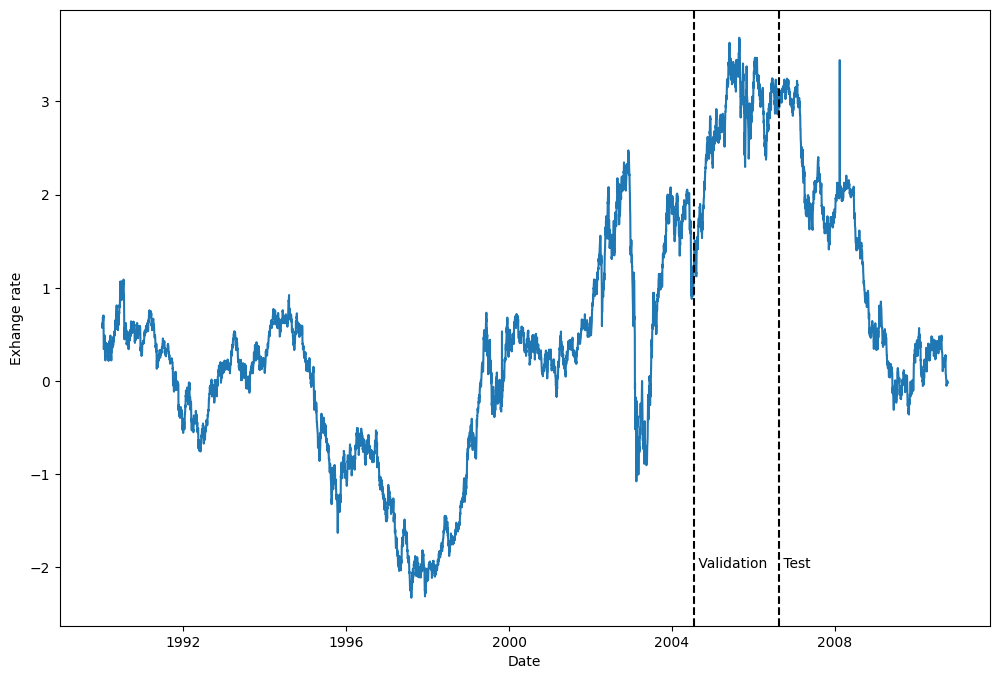

In [12]:
#Plot the time series for the first country, visualizing the training, validation and test parts
u_id = '0'

x_plot = pd.to_datetime(YX_df[YX_df.unique_id==u_id].ds)
y_plot = YX_df[YX_df.unique_id==u_id].y.values

x_plot

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')

plt.text(x_val, -2, ' Validation', fontsize=10)
plt.text(x_test,-2, ' Test', fontsize=10)

plt

In [13]:
#Set the horizon and configure the models for training
horizon = 92

models = [NHITS(h=horizon,
               input_size=12*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=12*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=12*horizon,
                 max_steps=50),
         MLP (h=horizon,
                 input_size=12*horizon,
                 max_steps=50),
         LSTM (h=horizon,
                 input_size=12*horizon,
                 max_steps=50),
         RNN (h=horizon,
                 input_size=12*horizon,
                 max_steps=50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [14]:
#train the models for cross validation to see which one is most accurate
nf = NeuralForecast(models=models, freq='D')
preds_df = nf.cross_validation(df=YX_df, val_size=val_size, test_size=test_size, n_windows=None)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
#Check the predictions dataset for each model
preds_df

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,MLP,LSTM,RNN,ex_1,ex_2,ex_3,ex_4,y
0,0,2006-08-16,2006-08-15,2.970718,2.928376,2.889250,2.851706,2.251868,3.004876,-0.5,-0.166667,0.000000,0.121918,2.948076
1,0,2006-08-17,2006-08-15,2.949558,2.890527,3.054430,2.793317,2.237102,2.996382,-0.5,0.000000,0.033333,0.124658,3.049320
2,0,2006-08-18,2006-08-15,2.938019,2.945896,2.872704,2.978765,2.221885,3.032683,-0.5,0.166667,0.066667,0.127397,3.064168
3,0,2006-08-19,2006-08-15,2.901763,2.938867,2.929369,2.955287,2.255347,3.143426,-0.5,0.333333,0.100000,0.130137,3.005783
4,0,2006-08-20,2006-08-15,2.874560,2.870369,2.957565,2.977109,2.195757,3.024585,-0.5,0.500000,0.133333,0.132877,3.010031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049531,OT,2010-10-06,2010-07-10,1.520877,1.152959,1.402144,0.768800,1.106513,1.402894,-0.5,-0.166667,-0.333333,0.261644,0.902640
1049532,OT,2010-10-07,2010-07-10,1.484145,1.125937,1.336609,0.597811,1.085433,1.399494,-0.5,0.000000,-0.300000,0.264384,0.953585
1049533,OT,2010-10-08,2010-07-10,1.496422,1.113721,1.408493,0.877931,1.082625,1.408344,-0.5,0.166667,-0.266667,0.267123,0.956124
1049534,OT,2010-10-09,2010-07-10,1.552968,1.127773,1.379479,0.762832,1.103571,1.390281,-0.5,0.333333,-0.233333,0.269863,0.921979


In [16]:
#save the dataset
output_file = 'predictions.csv'
preds_df.to_csv(output_file, index=False)

In [17]:
#transform the predictions into array shapes for plotting them later
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values
y_pred_mlp = preds_df['MLP'].values
y_pred_lstm = preds_df['LSTM'].values
y_pred_rnn = preds_df['RNN'].values

n_series = len(YX_df['unique_id'].unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)
y_pred_mlp = y_pred_mlp.reshape(n_series, -1, horizon)
y_pred_lstm = y_pred_lstm.reshape(n_series, -1, horizon)
y_pred_rnn = y_pred_rnn.reshape(n_series, -1, horizon)

print(y_true.shape)
print(y_pred_nhits.shape)
print(y_pred_nbeats.shape)
print(y_pred_patchtst.shape)
print(y_pred_mlp.shape)
print(y_pred_lstm.shape)
print(y_pred_rnn.shape)

(8, 1426, 92)
(8, 1426, 92)
(8, 1426, 92)
(8, 1426, 92)
(8, 1426, 92)
(8, 1426, 92)
(8, 1426, 92)


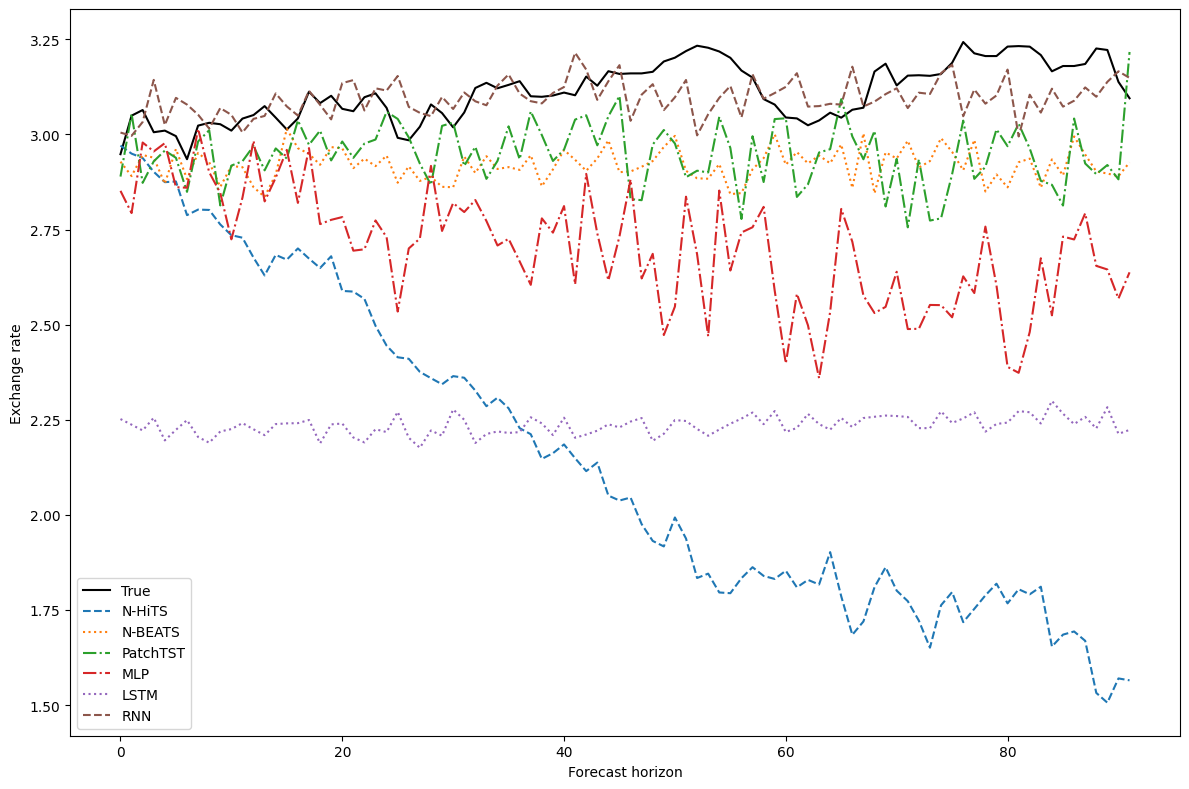

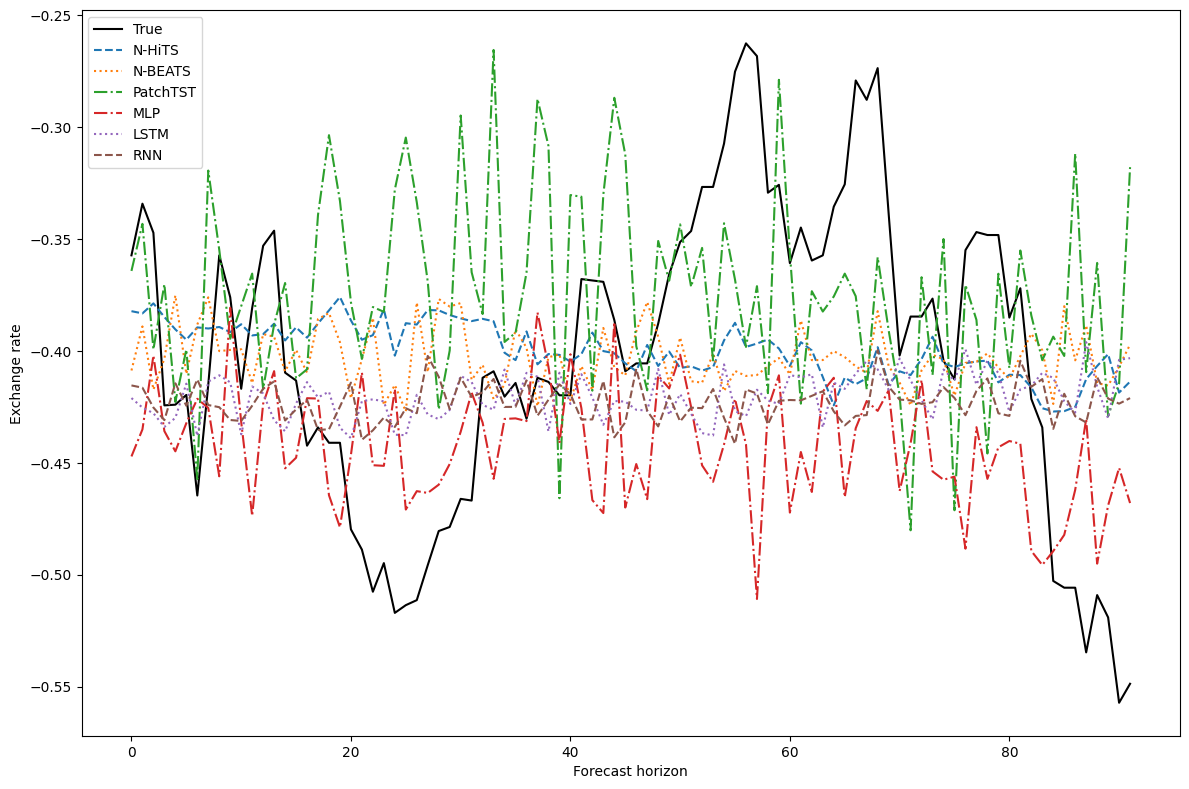

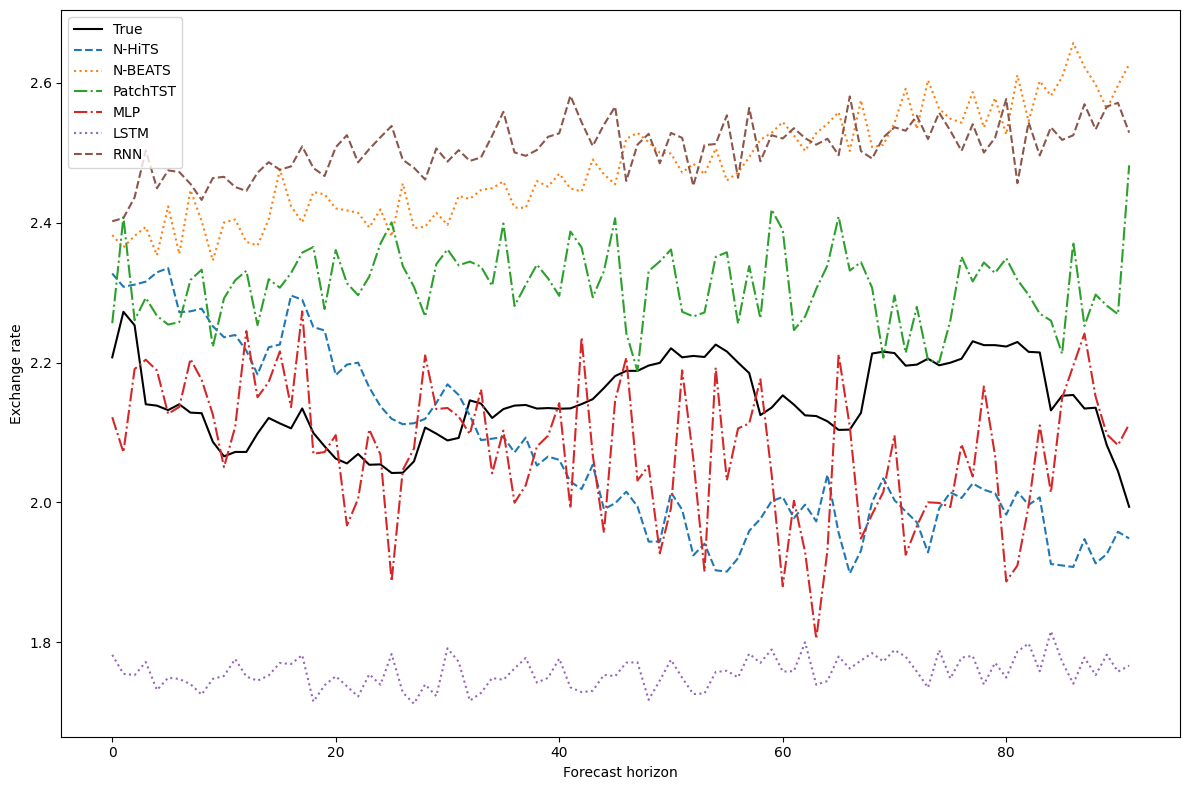

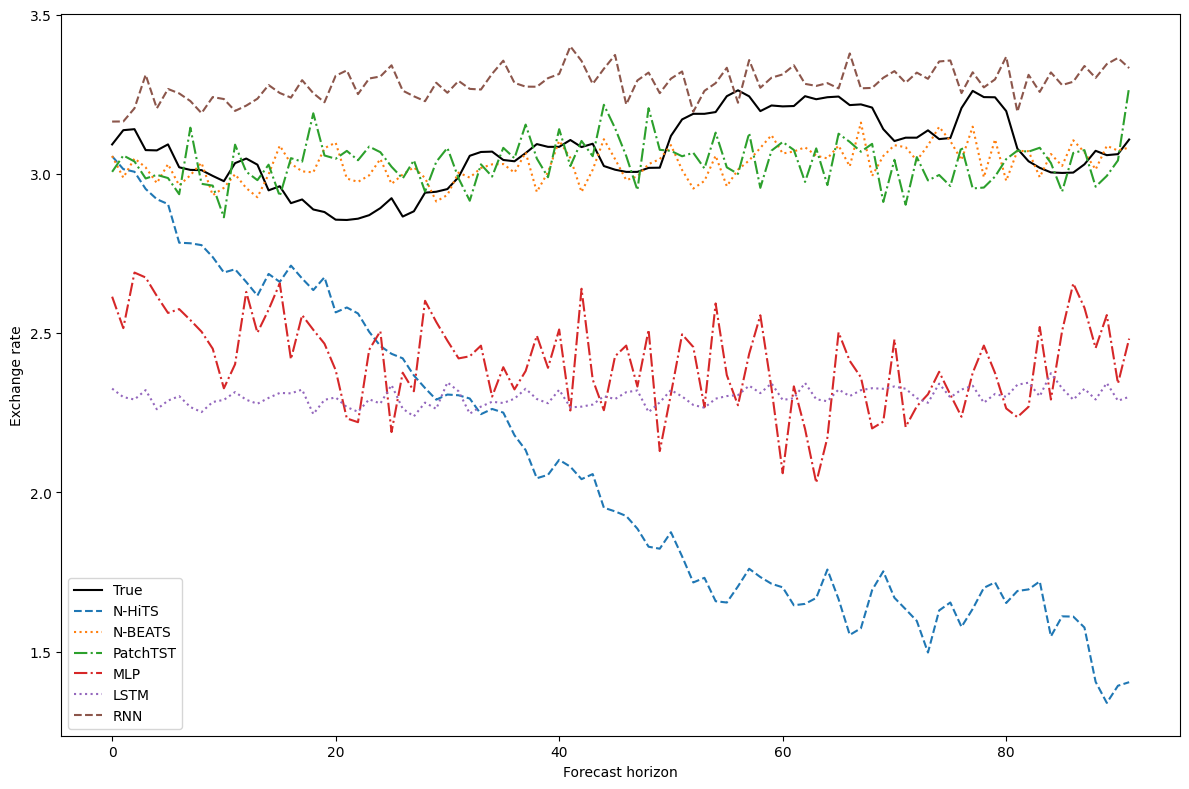

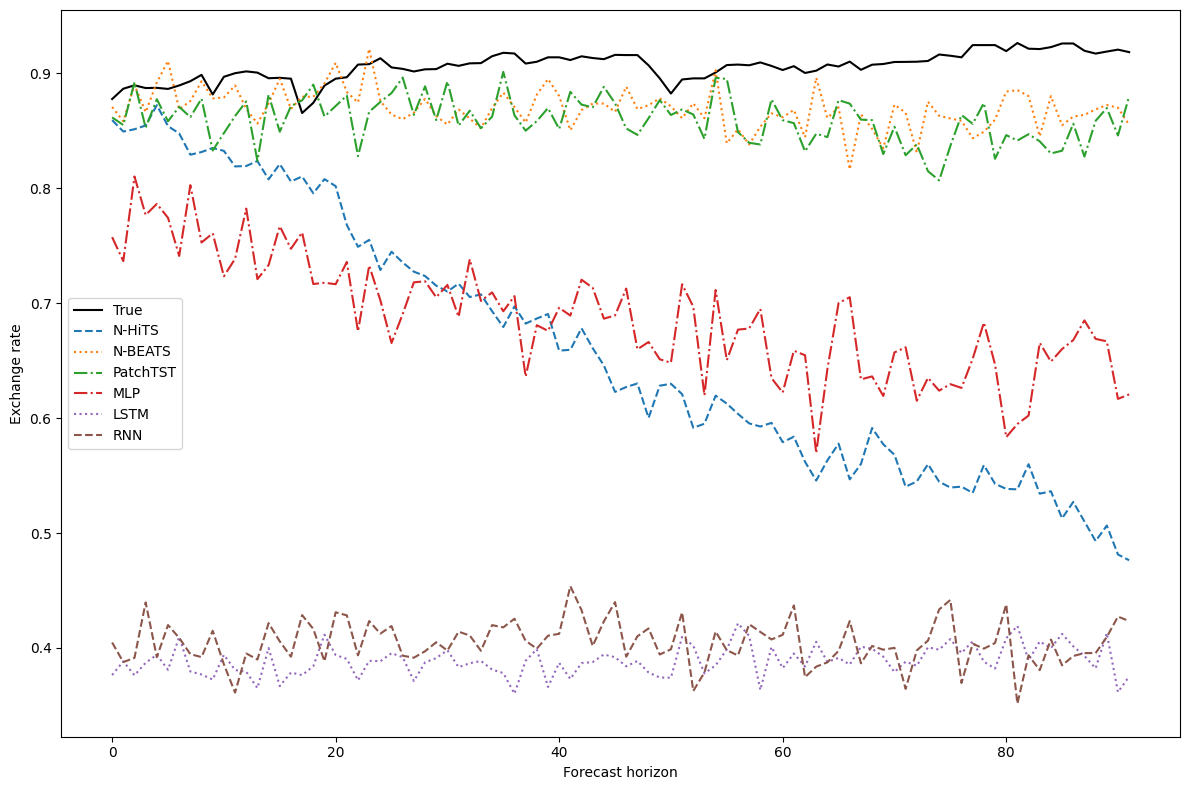

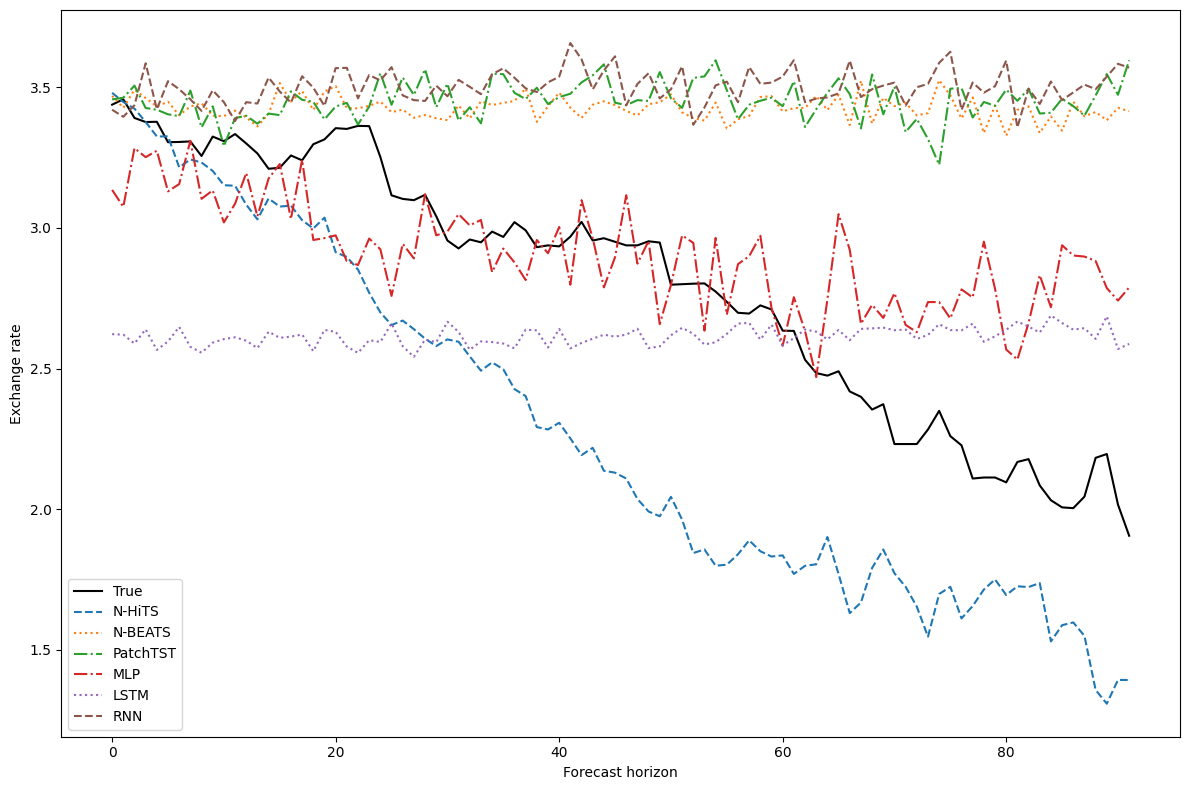

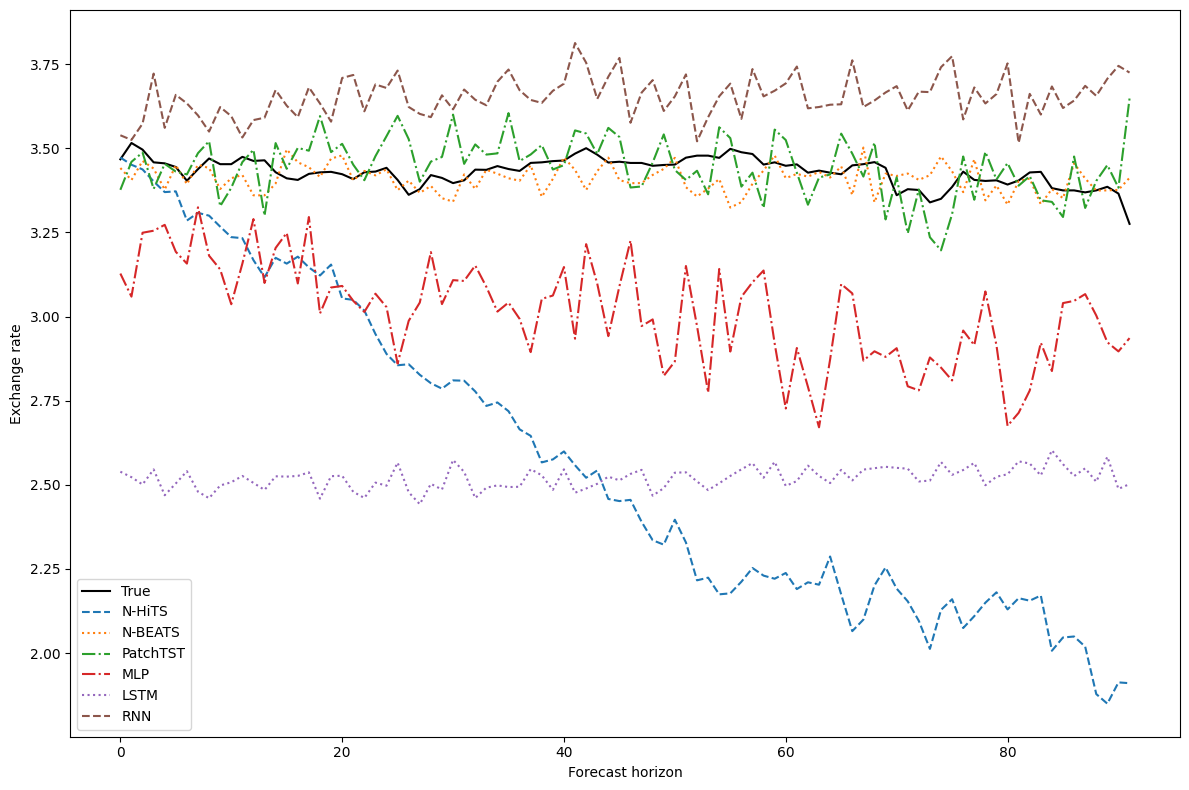

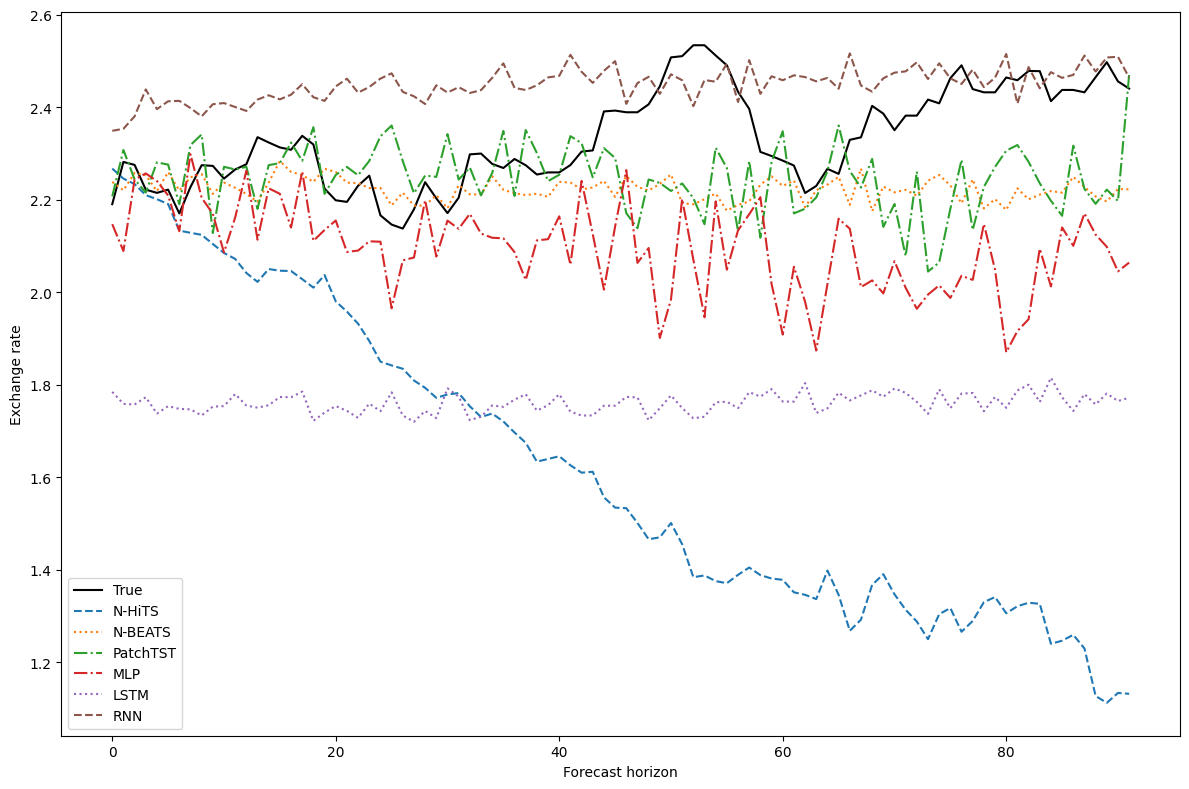

In [18]:
#Let's plot some of those predictions; we'll plot the first patch ("0") for every country, using a for-loop

for num, unique in enumerate(preds_df.unique_id.unique()):
  fig, ax = plt.subplots(figsize=(12,8))

  ax.plot(y_true[num, 0, :], label='True', color= 'black')
  ax.plot(y_pred_nhits[num, 0, :], label='N-HiTS', ls='--')
  ax.plot(y_pred_nbeats[num, 0, :], label='N-BEATS', ls=':')
  ax.plot(y_pred_patchtst[num, 0, :], label='PatchTST', ls='-.')
  ax.plot(y_pred_mlp[num, 0, :], label='MLP', ls='-.')
  ax.plot(y_pred_lstm[num, 0, :], label='LSTM', ls=':')
  ax.plot(y_pred_rnn[num, 0, :], label='RNN', ls='--')

  ax.set_ylabel('Exchange rate')
  ax.set_xlabel('Forecast horizon')
  ax.legend(loc='best')

  plt.tight_layout()

In [19]:
#Let's plot a table with the metrics (mae and mse) for every model
data = {'N-HiTS': [mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
       'N-BEATS': [mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
       'PatchTST': [mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)],
       'MLP': [mae(y_pred_mlp, y_true), mse(y_pred_mlp, y_true)],
       'LSTM': [mae(y_pred_lstm, y_true), mse(y_pred_lstm, y_true)],
       'RNN': [mae(y_pred_rnn, y_true), mse(y_pred_rnn, y_true)]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='green', axis=1)

,N-HiTS,N-BEATS,PatchTST,MLP,LSTM,RNN
mae,0.305395,0.251134,0.206101,0.471344,0.387691,0.299089
mse,0.211466,0.119408,0.085914,0.348701,0.222247,0.147586


In [20]:
# Fit and predict 92 data points using the PatchTST model
horizon = 92
models = [PatchTST(input_size=12 * horizon, h=horizon, max_steps=50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [21]:
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=YX_df)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
Y_hat_df = nf.predict().reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
#Let's see the dataset with the predictions
Y_hat_df

,unique_id,ds,PatchTST
0,0,2010-10-11,0.041190
1,0,2010-10-12,-0.030172
2,0,2010-10-13,0.018255
3,0,2010-10-14,-0.018675
4,0,2010-10-15,-0.035052
...,...,...,...
731,OT,2011-01-06,0.836700
732,OT,2011-01-07,1.005299
733,OT,2011-01-08,0.972985
734,OT,2011-01-09,0.928630


In [24]:
#Let's merge the y true values and the predictions for a later plot
merged_df = Y_hat_df.merge(YX_df[['ds', 'y', 'unique_id']], on=['ds', 'unique_id'], how='outer')
merged_df

,unique_id,ds,PatchTST,y
0,0,2010-10-11,0.041190,NaN
1,0,2010-10-12,-0.030172,NaN
2,0,2010-10-13,0.018255,NaN
3,0,2010-10-14,-0.018675,NaN
4,0,2010-10-15,-0.035052,NaN
...,...,...,...,...
61435,OT,2010-10-06,NaN,0.902640
61436,OT,2010-10-07,NaN,0.953585
61437,OT,2010-10-08,NaN,0.956124
61438,OT,2010-10-09,NaN,0.921979


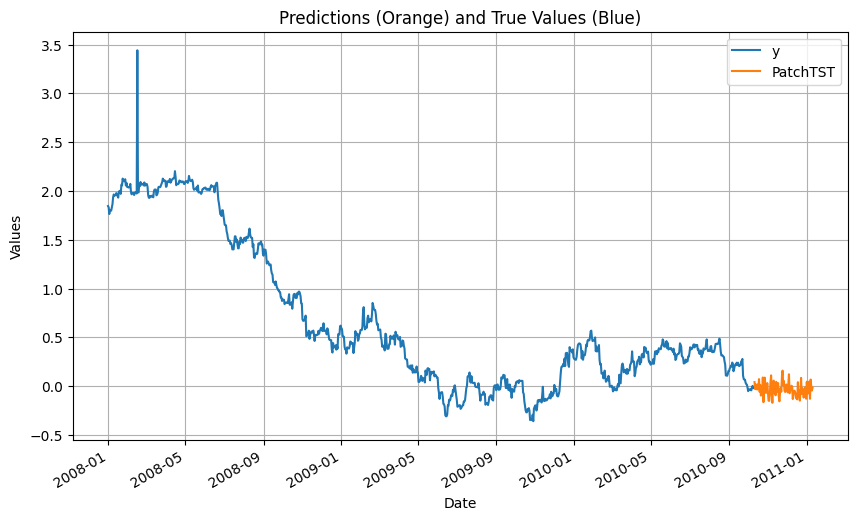

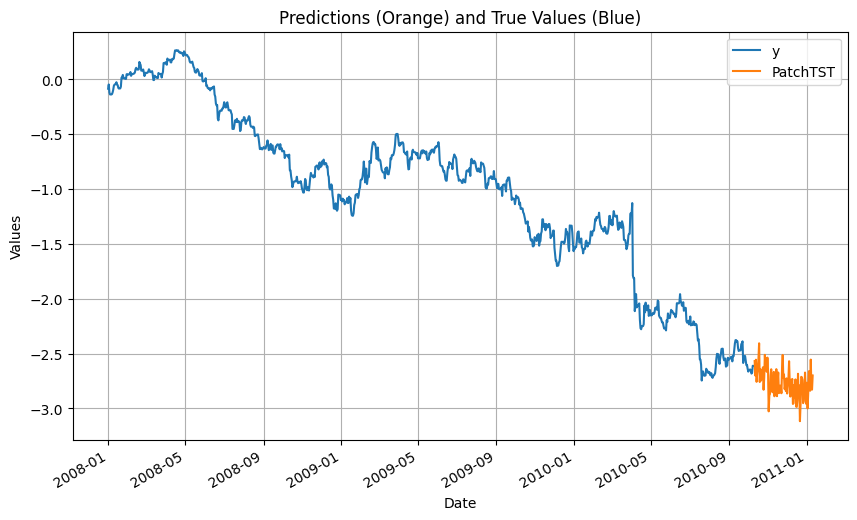

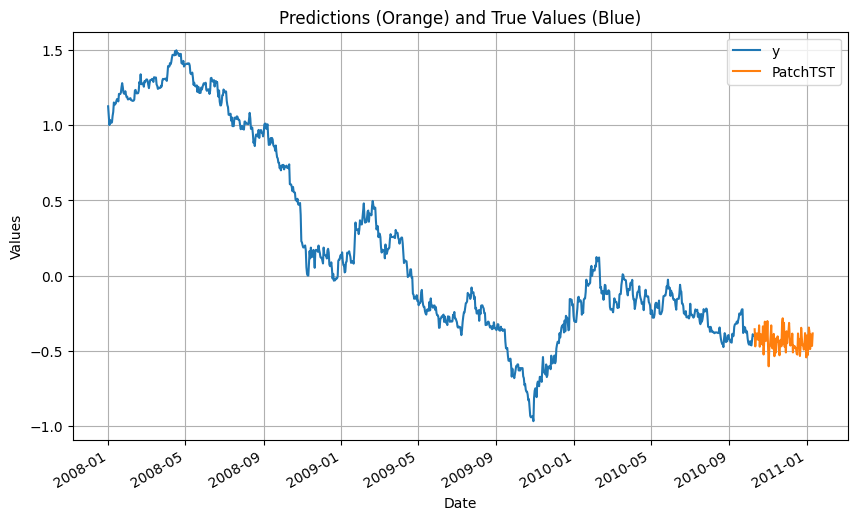

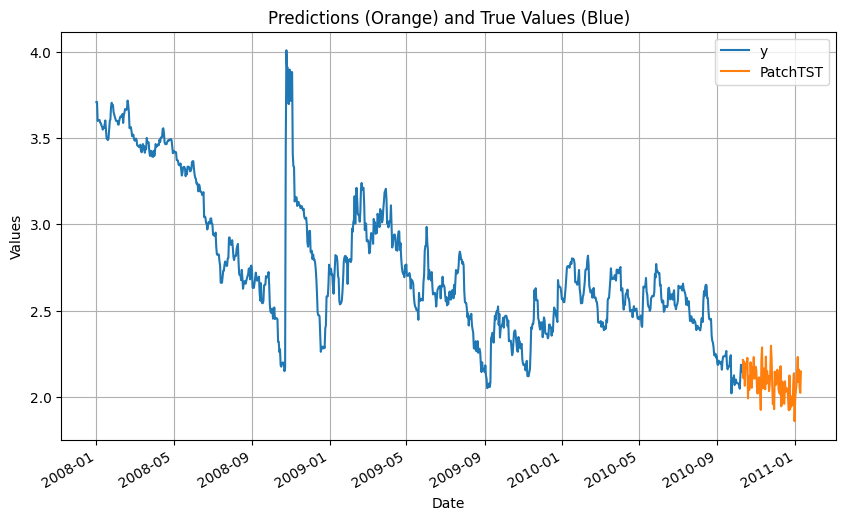

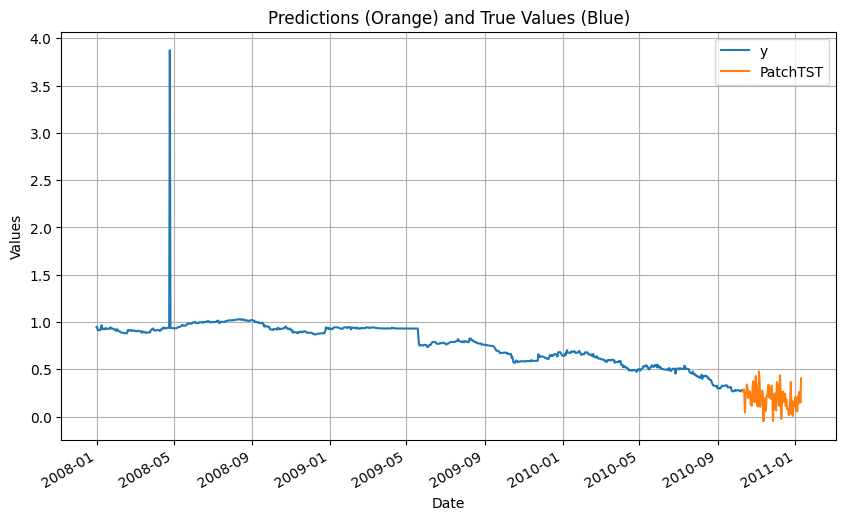

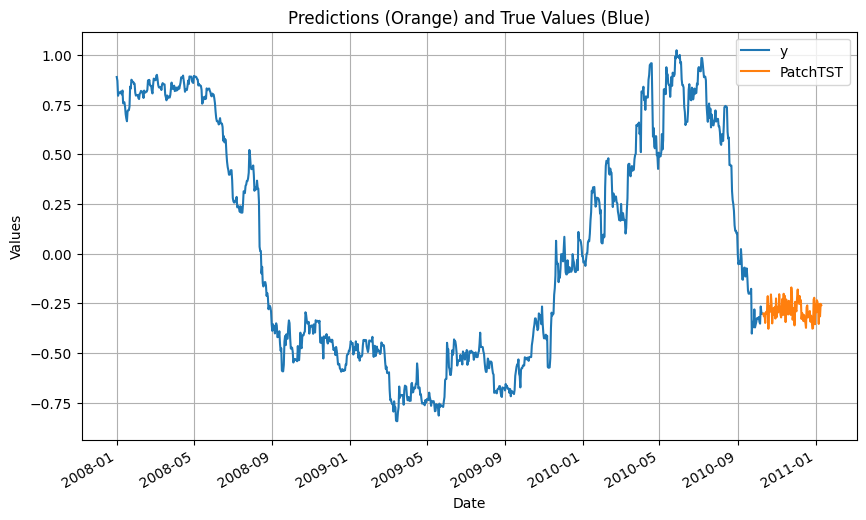

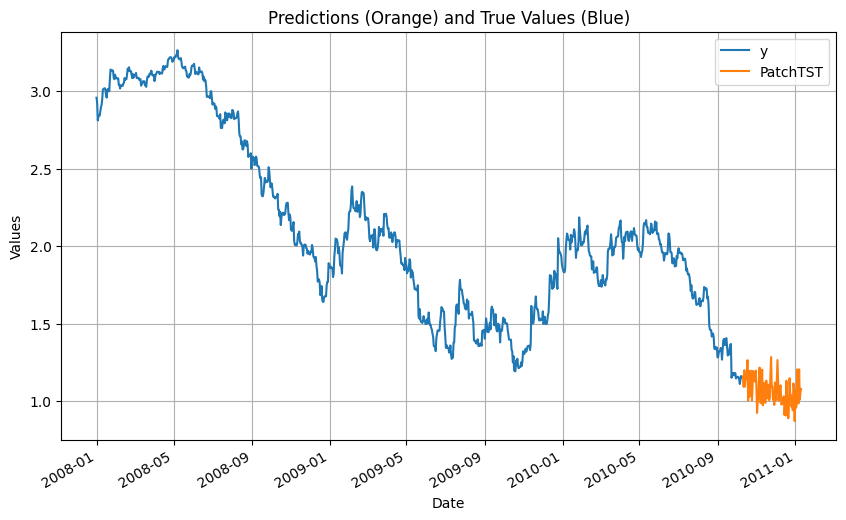

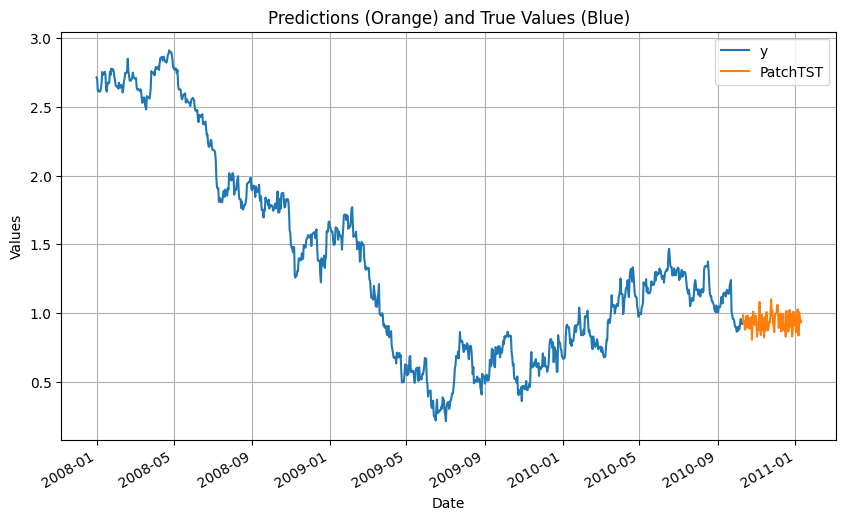

In [25]:
#Let's plot the predictions (and real values from 2008) for every country using a for-loop

plot_df= merged_df[merged_df.ds >= '2008-01-01']

for unique in merged_df.unique_id.unique():
  plot_df[merged_df.unique_id==unique].plot(x='ds', y=['y', 'PatchTST'], figsize=(10, 6), grid=True)
  plt.title("Predictions (Orange) and True Values (Blue)")
  plt.xlabel("Date")
  plt.ylabel("Values")
  plt.show()